# Task one

# Mathematical background

## Fitting single harmonics

We fit single harmonics to the anomalous data (data values minus the mean) using a Fourier transform to find the coefficients 
$$ A_k = \frac{2}{n}\sum_{i=1}^{n}y_n\cos\left(\frac{2\pi i k}{n}\right)$$
and
$$ B_k = \frac{2}{n}\sum_{i=1}^{n}y_n\sin\left(\frac{2\pi i k}{n}\right)$$
of
$$ y_i - \overline{y} = A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right) $$

Here $k$ is the harmonic being fitted to the anomaly of some data.
To carry this out we write a function `fourier_coeffs` to which calculates $A_{k}$ and $B_{k}$ as well as functions to compute the sine and cosine sums.

This will be used for both water and air temperature to fit a few discrete harmonics.

In [13]:
function fourier_coeffs(y, k)
    n = length(y)
    i = 1:n
    Aₖ = (2 / n) * sum(y .* cos.((2 * π * i * k) / n))
    Bₖ = (2 / n) * sum(y .* sin.((2 * π * i * k) / n))
    return [Aₖ, Bₖ]
end

fourier_coeffs (generic function with 1 method)

In [14]:
@. cosfunc(i, k, N) = sum( cos( (2*π*i*k) / N) )
@. sinfunc(i, k, N) = sum( sin( (2*π*i*k) / N) )

sinfunc (generic function with 1 method)

## Spectral density

We can look at the spectral density of the sea level by using a power spectrum (or periodogram) to see how the processes at different speed contribute to a time series.
This arises by considering the Fourier coefficients $A_{k}$ and $B_{k}$ above as functions of frequency - that is how 
$$
C_{k}^{2} = A_{k}^{2} + B_{k}^{2}
$$
varies as the frequency $f_{k} = $ varies.

In doing so we encounter the *Nyquist frequency* and aliasing errors.
The *Nyquist frequency* executes $\frac{n}{2}$ cycles over the full data and depends on the temporal resolution of the data.
This limits the information available from and spectral analysis because there are only so many allowable frequencies for a data set that are determined by the number of cycles in the data.
Hence the spectra are only computed up to this $n$ determined by the Nyquist frequency. 

This can be computed by using the function `C_k` below which computes $C_{k}$ from the function `fourier_coeffs`.
The *Nyquist frequency* determines the value $n$ so for the periodogram we compute the $C_{k}$ corresponding to the $\frac{n}{2}-1$ spectra then determine the $A_{k}$ and $B_{k}$ coefficients for $\frac{n}{2}$ by
$$
A_{n/2} = 
\begin{cases}
    \frac{1}{n} \sum_{i}^{n}y_{i}\cos(\pi i) & n \text{ even} \\
    0 & n \text{ odd} 
\end{cases}
$$
and 
$$
B_{n/2} = 
\begin{cases}
    0 & n \text{ even} \\
    0 & n \text{ odd} 
\end{cases}
$$

In [15]:
function C_k(y, k)
    F_coeffs = fourier_coeffs(y, k)
    return F_coeffs[1]^2 + F_coeffs[2]^2
end

C_k (generic function with 1 method)

The above function will compute the appropriate Fourier coefficients however it is not very well optimised and as this data set is reasonably large we can use the `FFTW.jl` package instead.
This uses the much more efficient fast Fourier transform algorithm to compute the complex Fourier coefficients for the data for all $k$.
Depending on the *Nyquist frequency* we then take the required coefficients from this set of complex Fourier coefficients (for the complex Fourier coefficients the real part $A_{k}$ and the imagainary part is $B_{k}$).

# Data

I have chosen to look at the data collected from Port Vila (on the island of Efate, Vanuatu) in 2017.
The data and metadata were downloaded from [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml) with further metadata (e.g. units of measurements, errors etc.) found [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/data.shtml).

The data contains hourly observations recorded between midnight (Universal Time Cooridnated time UTC) 1st January 2017 and 23:00 (UTC) 31st December 2017 of:
* sea Level (metres above tide gauge = 0)
* water temperature (degrees celsius)
* air temperature (degrees celsius)
* barometric pressure (hectopascals)
* residuals (measure of discrepancy between observed sea level and predicted sea level, metres)
* adjusted residuals (measure of discrepancy between observed sea level and predicted sea level adjusted for static barometric pressure effect, metres)
* wind direction (degrees true)
* wind gust (metres per second)
* wind speed (metres per second)

from latitude 17° 45' 41" S and longtitude 168° 17' 35" E.

The total number of observations recorded is 8760.
## Source of data

The data is provided by the Australian Bureau of Meterology and comes from the *Pacific Sea Level and Geodetic Monitoring Project*.

## Display and describe data

First load in the data and see inspect it using summaries and plots.
For this task we are interested in the water temperature, the air temperature and the sea level so we only read in these columns along with the date and time (rather than the whole file).

In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [2]:
using CSV, DataFrames, Plots, Dates, Statistics, FFTW, Suppressor

In [3]:
vanuatu_2017 = @suppress begin #This is just to suppress unnecessary warnings
    CSV.File("IDO70009_2017.csv"; drop = ["Barometric Pressure", "Residuals", "Adjusted Residuals", "Wind Direction", "Wind Gust", "Wind Speed", "Vanuatu"]) 
end
df_van = DataFrame(vanuatu_2017) 
first(df_van, 10)

,Date & UTC Time,Sea Level,Water Temperature,Air Temperature
,String31,Float64,Float64,Float64
1,01-Jan-2017 00:00,1.007,28.0,27.5
2,01-Jan-2017 01:00,0.88,28.0,28.0
3,01-Jan-2017 02:00,0.799,28.0,28.2
4,01-Jan-2017 03:00,0.787,28.1,27.0
5,01-Jan-2017 04:00,0.864,28.1,26.9
6,01-Jan-2017 05:00,1.004,27.9,27.4
7,01-Jan-2017 06:00,1.169,27.9,26.9
8,01-Jan-2017 07:00,1.299,27.9,24.2
9,01-Jan-2017 08:00,1.366,27.9,24.5


In [4]:
describe(df_van)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Date & UTC Time,,01-Apr-2017 00:00,,31-Oct-2017 23:00,0
2,Sea Level,-32.2527,-9999.0,0.86,1.611,0
3,Water Temperature,-139.772,-9999.0,27.0,31.0,0
4,Air Temperature,-7.48828,-9999.0,25.6,32.7,0


In total there are 8760 observations.
From the summaray of the data above there are minimum entries in all measureable columns of -9999. 
We do not remove these errors here as we may remove a row that has an error in one variable but not another.
Instead we reomve the errors in the single variable data frames below.
As well the date and time minimum and maximum are related to alphabetical ordering rather then temporal ordering as they are strings.
Using the `Dates.jl` package we create a new column for the date and time which orders things temporally.
These entries are **errors in the data** so below, when we are working in smaller dataframes, these are removed before plotting and fitting harmonics or spectral density power.

For convenience the variables are renamed to something without white space and a little shorter.

In [5]:
rename!(df_van, ["datetime", "sea_level", "water_temp", "air_temp"]);

The `datetime` variable is a string however julia has a package to deal with dates which we are going to use.
To take advantage of the `Dates.jl` package, we need to create a new column that has date and time in a julia `DateTime` format.
This is done below then we take another look at the desecription of the data and see the new date time column has minimum of the first entry and maximum of the last entry.
This is not strictly necessary except that it is easier to work with these `DateTime` formats than strings later on.

In [6]:
new_date = DateTime(2017, 1, 1, 00, 00, 00):Dates.Hour(1):DateTime(2017, 12, 31, 23, 00, 00)
insertcols!(df_van, 2, :datetime2 => new_date)
describe(df_van)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime,,01-Apr-2017 00:00,,31-Oct-2017 23:00,0
2,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
3,sea_level,-32.2527,-9999.0,0.86,1.611,0
4,water_temp,-139.772,-9999.0,27.0,31.0,0
5,air_temp,-7.48828,-9999.0,25.6,32.7,0


## Extract and clean data for `Sea level`, `Water Temperature`, and `Air Temperature`.
We are interested in the `Sea level`, `Water Temperature`, and `Air Temperature`, so we can create separate `DataFrames` for each of these variables (that also includes the date and time).

For `Water Temperature` and `Air Temperature` the data is cleaned and we look to fit some harmonics to the data.
For `Sea level` we do the same then look to compute the spectral density of the data.

In [7]:
sea_lvl = select(df_van, :datetime2, :sea_level)
w_temp = select(df_van, :datetime2, :water_temp)
a_temp = select(df_van, :datetime2, :air_temp);

Now we take a look at these dataframes individually

## Water temperature

First look at what the data for water temperature.
The summary below shows there are errors (given value -9999.0) so we remove all observations from `w_temp` that take the value -9999.0.

In [8]:
find = findall(w_temp[:, 2] .== -9999.0)
delete!(w_temp, find);

Now we check the plot and description of the data and see if this has taken care of things or if more needs to be done.

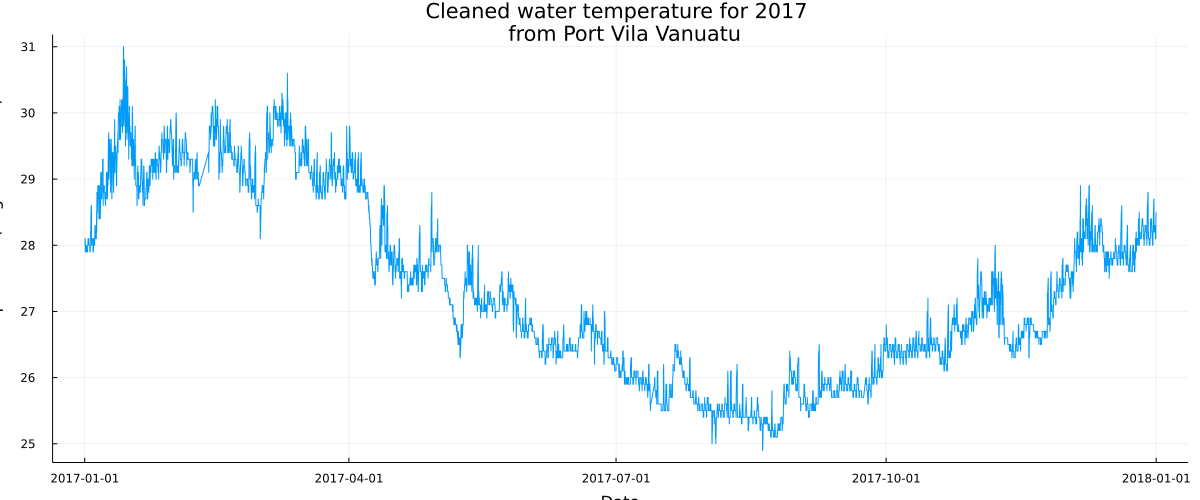

In [9]:
plot(w_temp[:, 1], w_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = false, 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (1200, 500))

In [10]:
describe(w_temp)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,water_temp,27.334,24.9,27.1,31.0,0


Removal of these errors seems to have taken care things.
The mean water temperature and median are close (27.334 and 27.1 respectively) and the water is warmest in the summer months, drops through autumn and is lowest in winter.

We are interested in the anomaly so we fit this then insert it into the data frame.
Now we look to fit discrete harmonics to the temperature anomaly data.
First get the water temperature anomaly data

In [11]:
wtemp_anom = w_temp[:, 2] .- mean(w_temp[:, 2])
insertcols!(w_temp, :w_anom => wtemp_anom)
first(w_temp, 5)

,datetime2,water_temp,w_anom
,DateTime,Float64,Float64
1,2017-01-01T00:00:00,28.0,0.666032
2,2017-01-01T01:00:00,28.0,0.666032
3,2017-01-01T02:00:00,28.0,0.666032
4,2017-01-01T03:00:00,28.1,0.766032
5,2017-01-01T04:00:00,28.1,0.766032


The harmonics are fitted using the `fourier_coeffs` function.
We will fit harmonics for $k = 1, 2, 3, 4$.

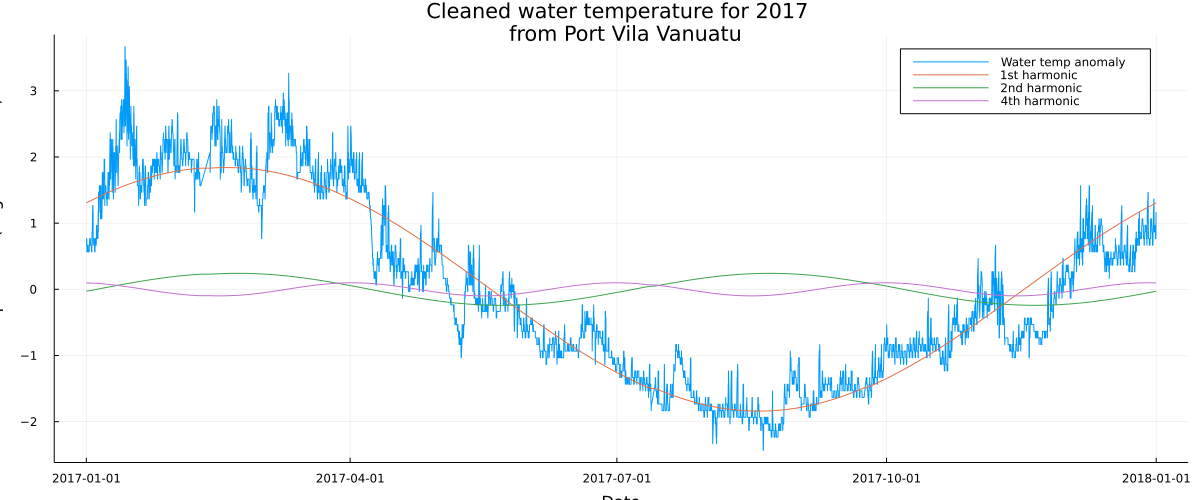

In [16]:
N = length(w_temp[:, 3])
i = range(1, N, step = 1)
k = [1, 2, 4]

# First harmonic
w_coeffs = fourier_coeffs(w_temp[:, 3], k[1])
water_first_harmonic = w_coeffs[1] * cosfunc(i, k[1], N) + w_coeffs[2] * sinfunc(i, k[1], N)
# Second harmonic 
w_coeffs = fourier_coeffs(w_temp[:, 3], k[2])
water_second_harmonic = w_coeffs[1] * cosfunc(i, k[2], N) + w_coeffs[2] * sinfunc(i, k[2], N)
# Fourth harmonic 
w_coeffs = fourier_coeffs(w_temp[:, 3], k[3])
water_fourth_harmonic = w_coeffs[1] * cosfunc(i, k[3], N) + w_coeffs[2] * sinfunc(i, k[3], N)

plot(w_temp[:, 1], w_temp[:, 3], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = "Water temp anomaly", 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (1200, 500))
plot!(w_temp[:, 1], water_first_harmonic, label = "1st harmonic")
plot!(w_temp[:, 1], water_second_harmonic, label = "2nd harmonic")
plot!(w_temp[:, 1], water_fourth_harmonic, label = "4th harmonic")


As there is only one macro cycle in this data (the annual warming and cooling of water temperature) and we have the data for one year the first harmonic does the best job of fitting.

The fit of the of the fourth harmonic is able to capture some of the smaller variations of the macro cycle but (unsurprisingly) neither the the second or the fourth harmonic provide much of a fit as we only have the data for one year.

The seasonal cycle can now be removed by subtracting the first harmonic from the temperature anomaly data.

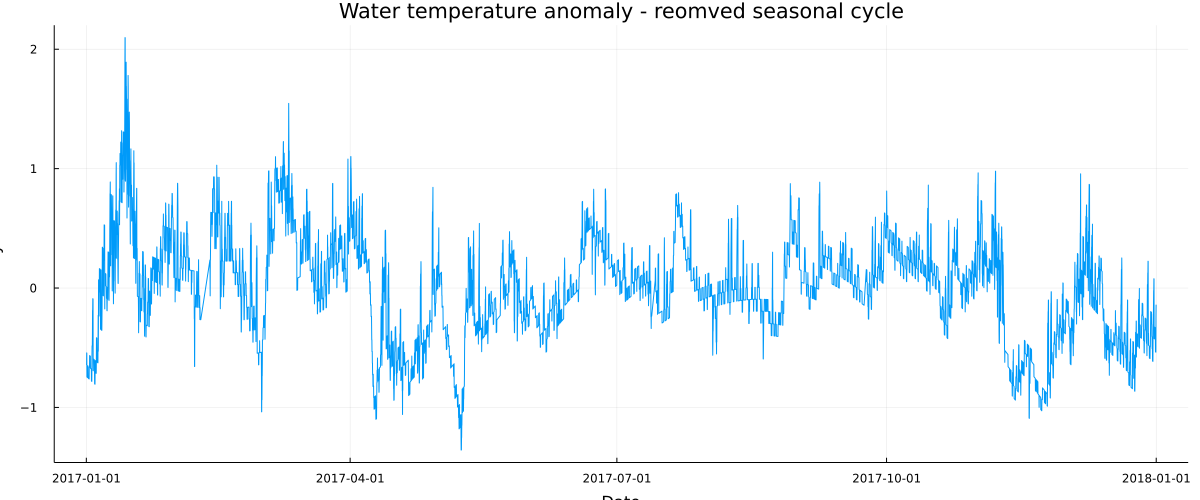

In [17]:
plot(w_temp[:, 1], w_temp[:, 3] .- water_first_harmonic, 
    xlabel = "Date", 
    ylabel = "water anomaly - 1st harmonic", 
    title = "Water temperature anomaly - reomved seasonal cycle",
    label = false,
    size = (1200, 500))

## Air temperature
Again remove the data entries corresponding to -9999.0 which are errors.

In [18]:
describe(a_temp)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,air_temp,-7.48828,-9999.0,25.6,32.7,0


In [19]:
find = findall(a_temp[:, 2] .== -9999.0)
delete!(a_temp, find);

Now we check to see if this has cleaned things up.

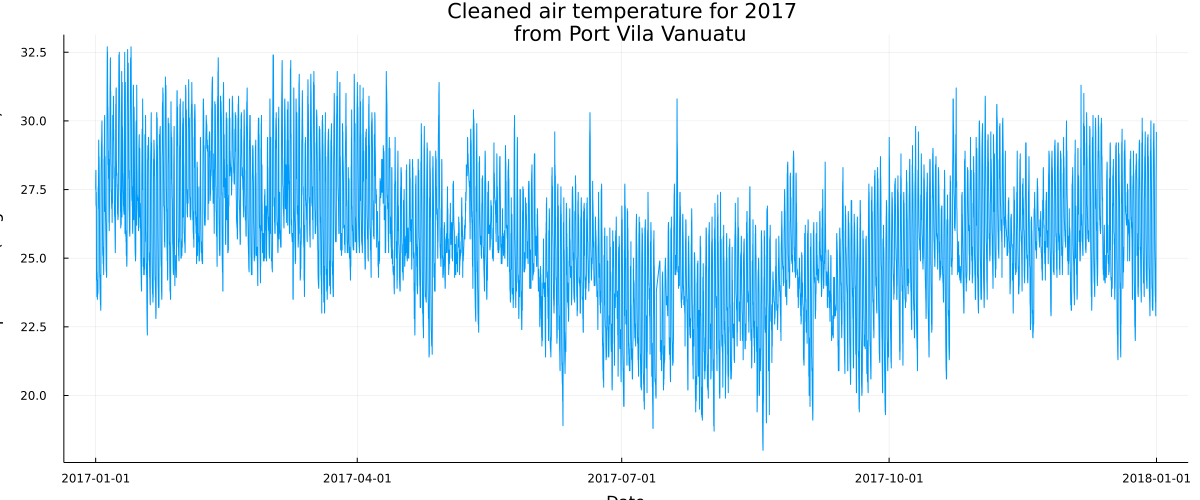

In [20]:
plot(a_temp[:, 1], a_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = false, 
    title = "Cleaned air temperature for 2017 \n from Port Vila Vanuatu",
    size = (1200, 500))

In [21]:
describe(a_temp)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,air_temp,25.6985,18.0,25.6,32.7,0


Again this has cleared things up.
The mean and median are now much closer (almost the same) and the air temperature follows the annual cycle of warmer in summer and cooler in winter.

We now fit some harmonics to the air temperature anomaly.
As this is also an annual shift from warmer to cooler, and we have one years worth of data, we expect that the first harmonic will best fit similarly to the water temperature anomaly.

In [22]:
atemp_anom = a_temp[:, 2] .- mean(a_temp[:, 2])
insertcols!(a_temp, :a_anom => atemp_anom)
first(a_temp, 5)

,datetime2,air_temp,a_anom
,DateTime,Float64,Float64
1,2017-01-01T00:00:00,27.5,1.80149
2,2017-01-01T01:00:00,28.0,2.30149
3,2017-01-01T02:00:00,28.2,2.50149
4,2017-01-01T03:00:00,27.0,1.30149
5,2017-01-01T04:00:00,26.9,1.20149


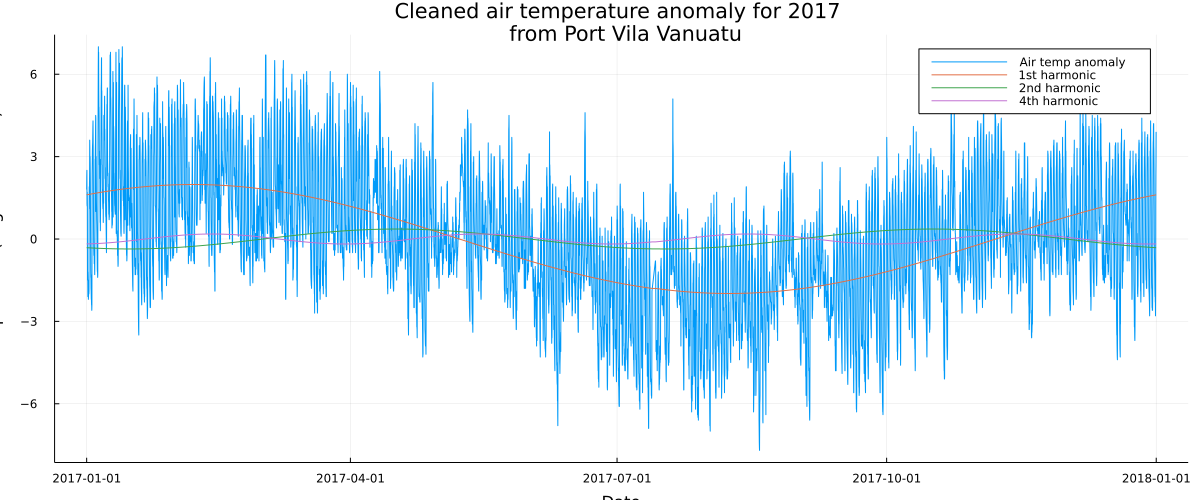

In [23]:
N = length(a_temp[:, 3])
i = range(1, N, step = 1)
k = [1, 2, 4]

# First harmonic
a_coeffs = fourier_coeffs(a_temp[:, 3], k[1])
air_first_harmonic = a_coeffs[1] * cosfunc(i, k[1], N) + a_coeffs[2] * sinfunc(i, k[1], N)
# Second harmonic 
a_coeffs = fourier_coeffs(a_temp[:, 3], k[2])
air_second_harmonic = a_coeffs[1] * cosfunc(i, k[2], N) + a_coeffs[2] * sinfunc(i, k[2], N)
# Fourth harmonic 
a_coeffs = fourier_coeffs(a_temp[:, 3], k[3])
air_fourth_harmonic = a_coeffs[1] * cosfunc(i, k[3], N) + a_coeffs[2] * sinfunc(i, k[3], N)

plot(a_temp[:, 1], atemp_anom, 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = "Air temp anomaly", 
    title = "Cleaned air temperature anomaly for 2017 \n from Port Vila Vanuatu",
    size = (1200, 500))
plot!(a_temp[:, 1], air_first_harmonic, label = "1st harmonic")
plot!(a_temp[:, 1], air_second_harmonic, label = "2nd harmonic")
plot!(a_temp[:, 1], air_fourth_harmonic, label = "4th harmonic")


As with the water temperature anomaly we have one year of data and the cycle is annual hence the 1st harmonic fits well to the data.
The second and fourth harmonic reveal very little here.

Using the first harmonic the seasonal variation can be removed as was done for the water temperature anomaly.

# Sea level
Again there is data corresponding to -9999.0 that needs to be removed.

In [24]:
find = findall(sea_lvl[:, 2] .== -9999.0)
delete!(sea_lvl, find);

In [25]:
plot(sea_lvl[:, 1], sea_lvl[:, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 from Port Vila Vanuatu",
    size = 1200, 500))

LoadError: syntax: extra token ")" after end of expression

In [ ]:
describe(sea_lvl)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0
2,sea_level,0.851854,-0.111,0.861,1.611,0


Again removing the observations that were entered as -9999.0 has cleared things up.
There are now

In [ ]:
length(sea_lvl[:, 1])

8731

observations in the data.

## Periodogram

We now fit a periodogram to the sea level for hours, days and months to look inspect the periodic behaviour over these periods.
The data is hourly so to transform it into days the number of observations (or total hours) is divided by 24.
To trasnform the data into months we make the simplfiying assumption that all months have 30 days.
This is reasonable because the 12 months of the year force the Nyquist freqeuncy to be 6, so we will look at January, February, March, April, May, June which when averaged have 

In [ ]:
(31 + 28 + 31 + 30 + 31 + 30) / 6

30.166666666666668

days per month.

### Fourier coefficients

Compute the Fourier coefficients using the real fast Fourier transfrom `rfft` from `FFTW.jl`.
Then extract the data that relates to days and months - that is, for days get a coefficient every 24 observations and for months get the coefficient at every 24*30 observations.

In [27]:
sealvl_coeffs = (2 / N) .* rfft(sea_lvl[:, 2], 1)
Cₖ = abs.(sealvl_coeffs)
Cₖ_hours = Cₖ[2:round(Int64, N / 2)]
Cₖ_12hours = Cₖ[13:12:round(Int64, N / 2)]
Cₖ_days = Cₖ[25:24:round(Int64, N / 2)]
Cₖ_months = Cₖ[25*30: 24*30 : round(Int64, N / 2)];

### Hourly period

For the hourly period we can see that after around 1000 hours there is not much going on, so a zoomed in plot of the first 1000 hours is also presented.

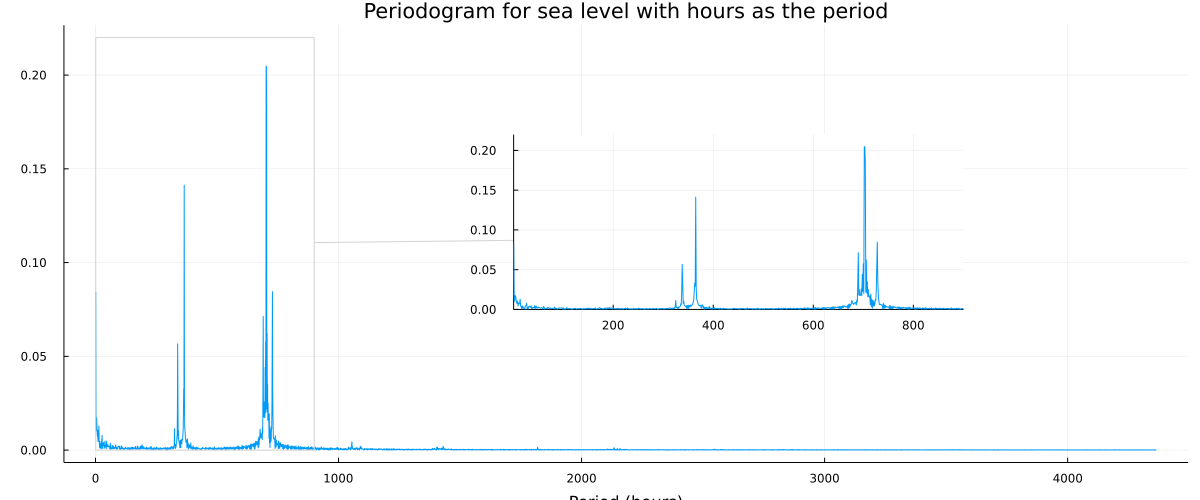

In [28]:
N = length(sea_lvl[:, 1]) #total number of hourly observations
hours_plot = 1:round(Int64, N / 2) - 1

plot(hours_plot, Cₖ_hours, 
    xlabel = "Period (hours)",
    ylabel = "Fourier Coefficent Cₖ",
    title = "Periodogram for sea level with hours as the period",
    label = false,
    size = (1200, 500))
lens!([1, 900], [0.0, 0.22], inset = (1, bbox(0.4, 0.25, 0.4, 0.4)))

The hours that have the most power are (approximately) 350 and around 700 and the beginning.
This means that there is a cycle occuring every approximately every 14 and 29 days as well as something happening every .

This is further inspected by considereing daily and montly periods.

### Day period

In [29]:
days = N / 24 #Number of days

363.7916666666667

Now create vector of days and the relevant Fourier Coefficients for the periodogram.

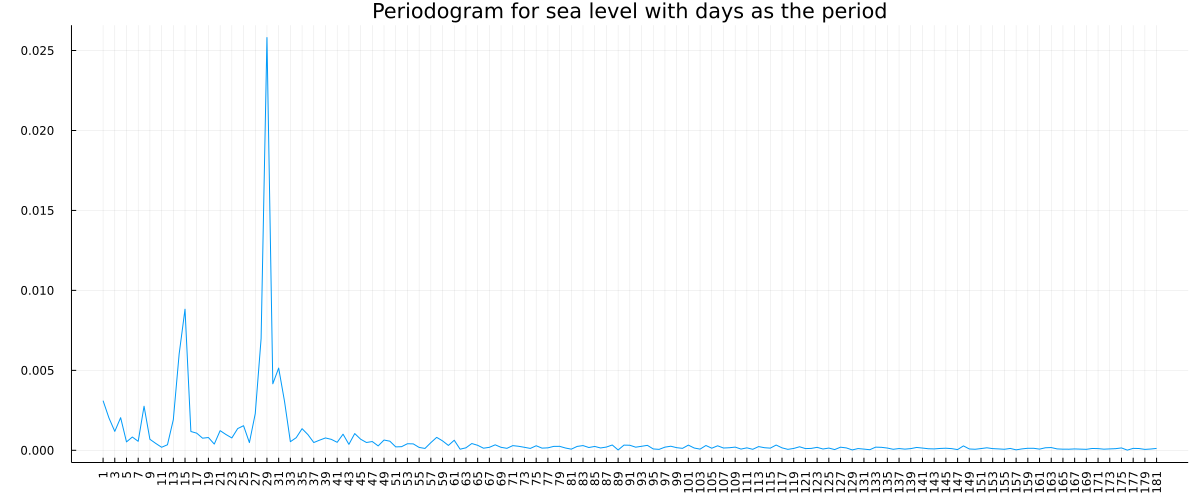

In [30]:
no_of_days = round(Int64, days / 2)
days_plot = 1:no_of_days - 1

plot(days_plot, Cₖ_days, 
    xlabel = "Period (days)",
    xticks = (1:2:181),
    xrotation = 90,
    ylabel = "Fourier Coefficent Cₖ",
    title = "Periodogram for sea level with days as the period",
    label = false,
    size = (1200, 500))

## Monthly period

Assuming there are 30 days in a month now compute the periodogram for the period of a month

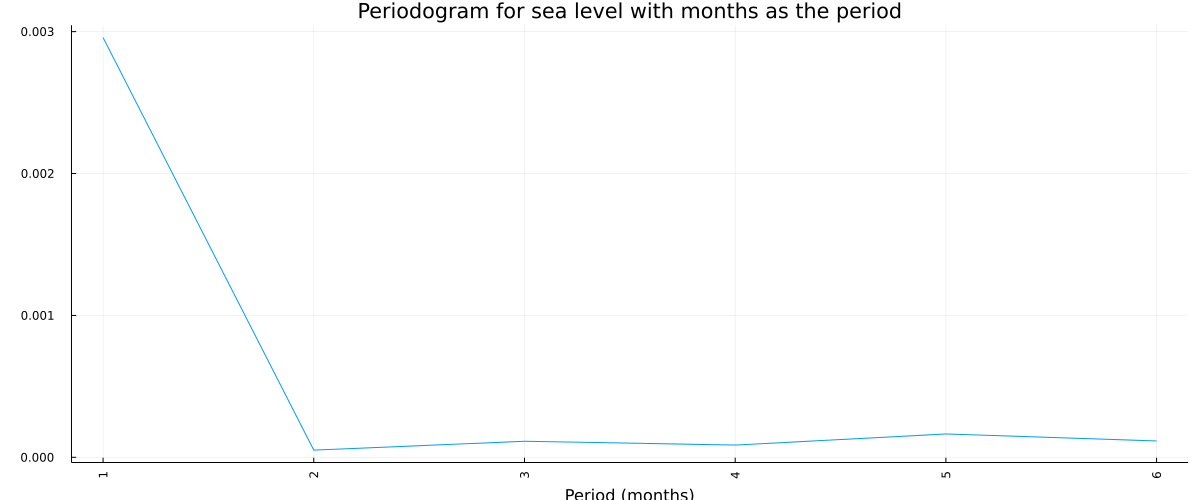

In [31]:
months = days / 30
no_of_months = round(Int64, months / 2)
months_plot = 1:no_of_months

plot(months_plot, Cₖ_months, 
    xlabel = "Period (months)",
    xticks = (1:6),
    xrotation = 90,
    ylabel = "Fourier Coefficent Cₖ",
    title = "Periodogram for sea level with months as the period",
    label = false,
    size = (1200, 500))

From the periodograms we see there is a cycle occuring every 14 and 29 days (approximately).
This fits with what happens to the tide during the lunar cycle which take 29.5 days.
The periodogram is capturing the spring and neap tides that are caused by the gravitational pull of the moon as it goes through the lunar cycle.

We look at the behaviour of the time series over a month, a week and a day to see what the data looks like and whether the periods indicated by periodogram are present.

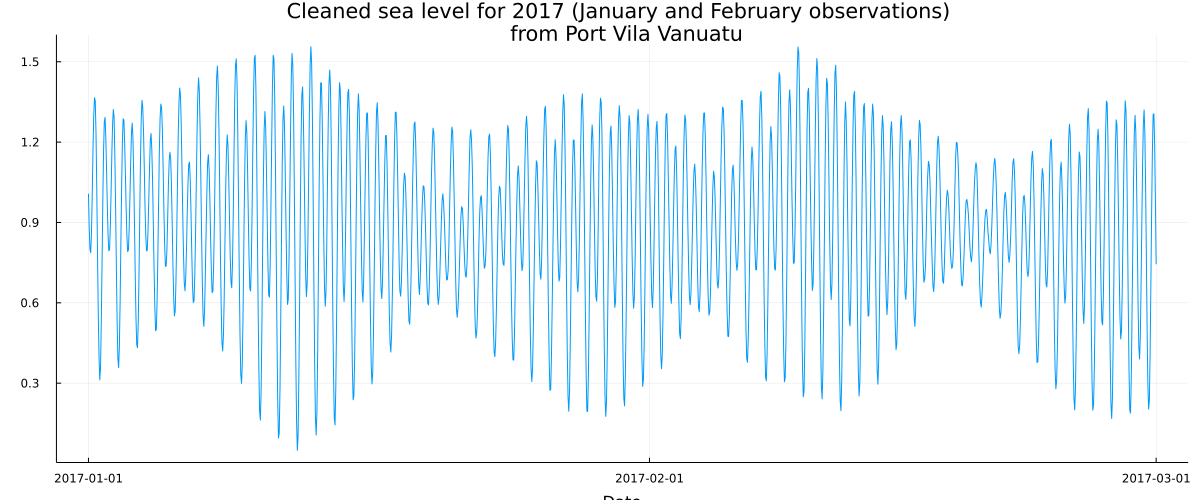

In [32]:
find_JanFeb = findfirst(sea_lvl[:, 1] .== DateTime(2017, 3, 1, 00, 00, 00))
plot(sea_lvl[1:find_JanFeb, 1], sea_lvl[1:find_JanFeb, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 (January and February observations) \n from Port Vila Vanuatu",
    size = (1200, 500))

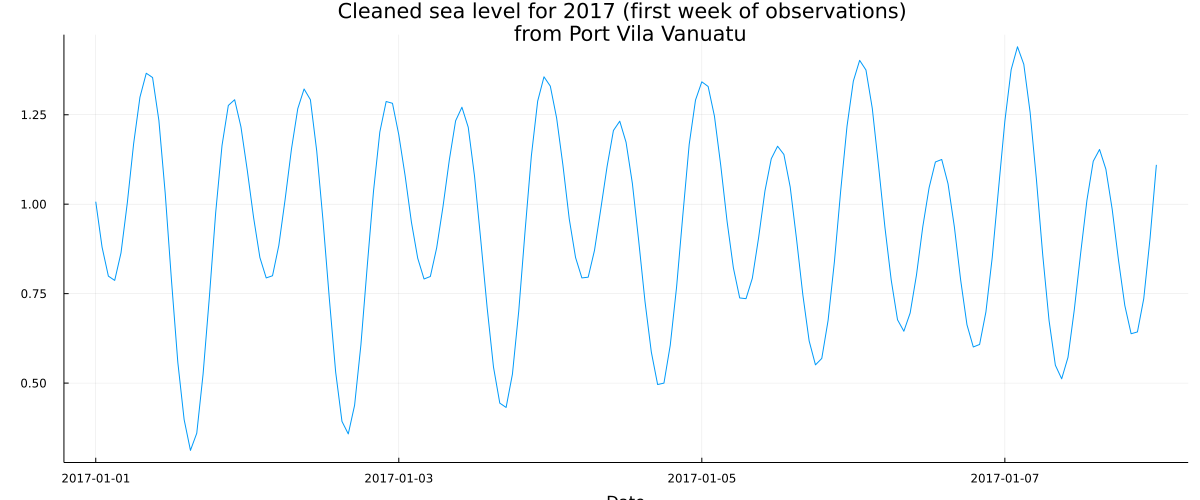

In [33]:
find_week = findfirst(sea_lvl[:, 1] .== DateTime(2017, 1, 8, 00, 00, 00))
plot(sea_lvl[1:find_week, 1], sea_lvl[1:find_week, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 (first week of observations) \n from Port Vila Vanuatu",
    size = (1200, 500))

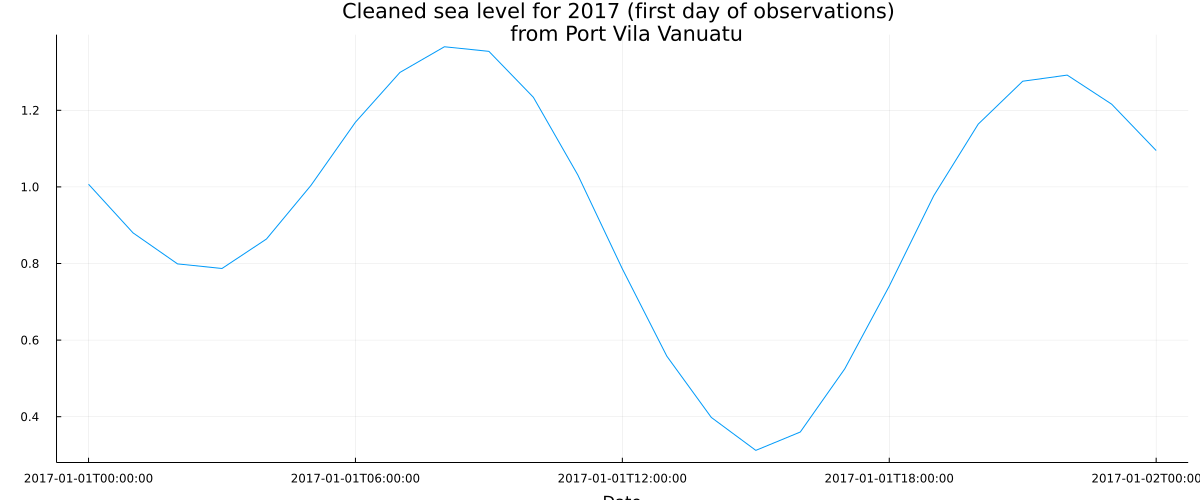

In [34]:
find_day = findfirst(sea_lvl[:, 1] .== DateTime(2017, 1, 2, 00, 00, 00))
plot(sea_lvl[1:find_day, 1], sea_lvl[1:find_day, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 (first day of observations) \n from Port Vila Vanuatu",
    size = (1200, 500))

The daily and weekly cycle shows the expected twice daily high and low tide and the two months of January and February show lunar cycle which has an effect on the magnitude on the high and low tide.

What is not captured by the periodogram (most likely due to my coding or misunderstanding!) is the 12 hour period or diurnal high and low tides..
There is some evidence of this cycle in both the hourly and daily data though it has much less power than the 14 and 29 day.

To inpsect this we now look at 12 hour period and see if it becomes apparent.

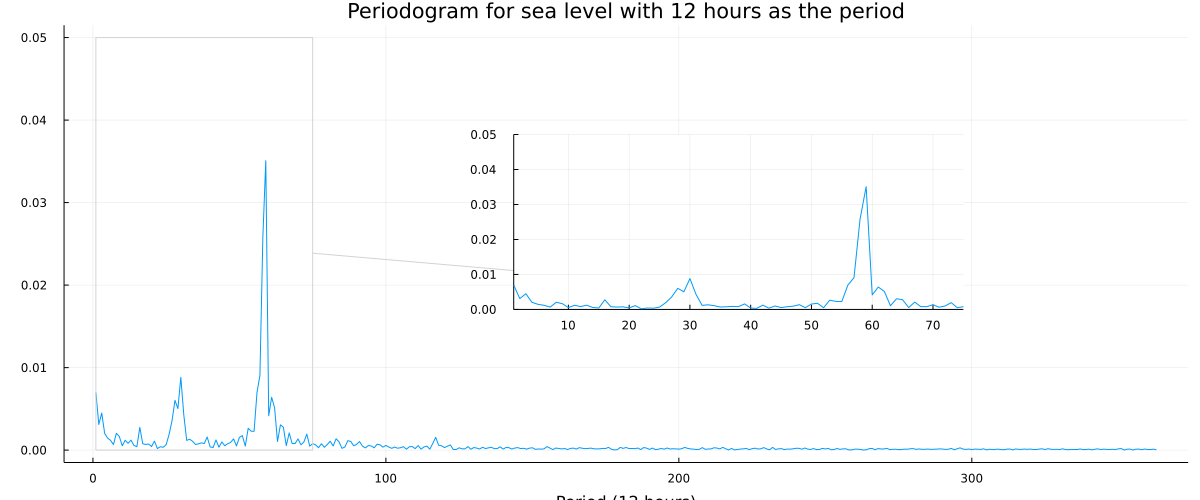

In [35]:
hours_12 = 2 * days 
no_of_12hour = round(Int64, hours_12 / 2)
hours12_plot = 1:no_of_12hour - 1

plot(hours12_plot, Cₖ_12hours, 
    xlabel = "Period (12 hours)",
    ylabel = "Fourier Coefficent Cₖ",
    title = "Periodogram for sea level with 12 hours as the period",
    label = false,
    size = (1200, 500))
lens!([1, 75], [0.0, 0.05], inset = (1, bbox(0.4, 0.25, 0.4, 0.4)))